
### *A toy example, explaing the forward and the backward propagation through the rolling convolution filters.*

*&emsp; &emsp; Input Shape : [1,3,3,3], &emsp; &emsp; &emsp; convolution filter : [1,3,2,2],  &emsp; &emsp; &emsp; Rolling Filter : [3,3,2,2],  &emsp; &emsp; &emsp; Output Shape : [1,3,2,2]*



---







In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

# Rolling Convolution Filters : **Back Propagation Using PyTorch**



In [2]:
# define the rolling network
torch.manual_seed(2000)

class RollingNet(nn.Module):

  def __init__(self):
    super(RollingNet, self).__init__()
    self.w = nn.Parameter(torch.randn(1,3,2,2))

  def roll(self, input, weight, stride = 1, padding=0):    
    w = weight
    s = stride
    p = padding
    rolls = w.size()[1]   
    for i in range(1,rolls+1):
      if i==1 :
        filter = w
      else:
        w = torch.roll(w, shifts = 1,  dims=1)
        filter = torch.cat((filter, w), dim=0)
    #print(filter)
    #print(filter.shape)
    return F.relu(F.conv2d(input,filter,None,s,p))

  def forward(self,x):
    out = self.roll(x,self.w)
    return out

net = RollingNet()

# define a sample input x
x = torch.randn(1,3,3,3)
x.requires_grad = True

print("x=\n\n", x)
print("\n")
print("Shape of x : ",x.shape)
print('\n\n')

print("w=\n\n", net.w)
print("\n")
print("Shape of w : ",net.w.shape)
print('\n\n')

out1 = net(x)
print("out1=\n\n",out1)
print("\n")
print("Shape of out1 : ",out1.shape)

# get a scalar output by using mean operator

print("\n")
out2 = out1.mean()
print("out2=\n\n",out2)
print("\n")

# let y = 10 be the groundtruth, assume mse loss

y =10

# compute loss and then perform back propagation
((y - out2)**2).backward()

# print gradients wrt w
print("Grad wrt w :\n\n ",net.w.grad.data)

print("\n")

# print gradients wrt x
print("Grad wrt x :\n\n ",x.grad.data)

x=

 tensor([[[[-0.7816,  0.3126, -0.6123],
          [-1.7910,  2.0015,  0.3848],
          [ 0.4734, -2.0544, -1.6954]],

         [[-1.0567,  1.4338,  0.8917],
          [-0.2352, -0.0765,  0.0058],
          [-1.5841, -0.2240, -0.5887]],

         [[-0.9784, -1.1509, -0.9075],
          [ 1.0140, -0.2201,  1.4911],
          [-0.4353,  0.7680, -1.1804]]]], requires_grad=True)


Shape of x :  torch.Size([1, 3, 3, 3])



w=

 Parameter containing:
tensor([[[[-0.5073,  0.2814],
          [-0.2256,  0.4173]],

         [[ 0.2403, -1.3501],
          [-0.4922,  0.0569]],

         [[ 0.1592,  0.7043],
          [-0.7137, -0.1834]]]], requires_grad=True)


Shape of w :  torch.Size([1, 3, 2, 2])



out1=

 tensor([[[[0.0000, 0.0000],
          [1.4977, 0.0000]],

         [[2.7747, 0.0000],
          [2.3238, 0.0000]],

         [[1.2611, 1.8488],
          [0.0000, 1.0011]]]], grad_fn=<ReluBackward0>)


Shape of out1 :  torch.Size([1, 3, 2, 2])


out2=

 tensor(0.8923, grad_fn=<MeanBackw

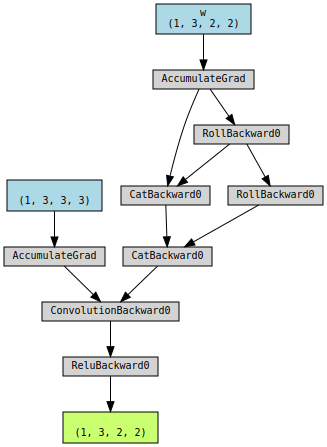

In [3]:
make_dot(net(x), params=dict(net.named_parameters()))

# Rolling Convolution Filters : **User Defined Back Propagation**



In [5]:
# define the rolling network
torch.manual_seed(2000)

class RollingNet(nn.Module):

  def __init__(self):
    super(RollingNet, self).__init__()
    self.w = nn.Parameter(torch.randn(1,3,2,2))

  def roll(self, input, weight, stride = 1, padding=0):    
    w = weight
    s = stride
    p = padding
    rolls = w.size()[1]   
    for i in range(1,rolls+1):
      if i==1 :
        filter = w
      else:
        w = torch.roll(w, shifts = 1,  dims=1)
        filter = torch.cat((filter, w), dim=0)
    #print(filter)
    #print(filter.shape)    
    return F.relu(F.conv2d(input,filter,None,s,p)),filter

  def forward(self,x):
    out = self.roll(x,self.w)
    return out

net = RollingNet()

# define a sample input x
x = torch.randn(1,3,3,3)
x.requires_grad = True


print("x=\n\n", x)
print("\n")
print("Shape of x : ",x.shape)
print('\n\n')

print("w=\n\n", net.w)
print("\n")
print("Shape of w : ",net.w.shape)
print('\n\n')

out1,filter = net(x)
print("out1=\n\n",out1)
print("\n")
print("Shape of out1 : ",out1.shape)

# get a scalar output by using mean operator

print("\n")
out2 = out1.mean()
print("out2=\n\n",out2)
print("\n")

# let y = 10 be the groundtruth, assume mse loss

y =10

# grad wrt out2

grad_out2 = -1 * 2 * (y - out2)
#print(grad_out2)

temp = (grad_out2/torch.numel(out1)).item()
#print(temp)

# grad wrt out1

grad_out1 = torch.full(out1.size(), temp)
# print(grad_out1.shape)

# grad after crossing relu 

grad_relu = (out1>0) * grad_out1

# grad with respect to x

grad_x = torch.full(x.size(), 0.0)

pad = filter.shape[2]-1

[b1,c1,h1,w1] = grad_x.shape

for j in range(0,c1):
  for i in range(0,grad_relu.shape[1]):
    grad_x[0,j,:,:] +=  nn.functional.conv2d(grad_relu[0:1,i:i+1,:,:], torch.flip(filter[i:i+1,j:j+1,:,:],[2,3]), None, 1, pad)[0,0,pad-1:h1,pad-1:w1]   

# print gradients wrt x
print("Grad wrt x :\n\n ",grad_x.data)

# grad with respect to w

grad_w = torch.full(net.w.size(), 0.0)

[b2,c2,h2,w2] = grad_w.shape

# rolling the gradients

for j in range(0,c2):
  for i in range(0,grad_relu.shape[1]):
    grad_w[0,j,:,:] +=  (nn.functional.conv2d(torch.roll(x,shifts=-i,dims=1)[0:1,j:j+1,:,:], grad_relu[0:1,i:i+1,:,:], None).squeeze(0)).squeeze(0)

print("\n")

# print gradients wrt x
print("Grad wrt W :\n\n ",grad_w.data)


x=

 tensor([[[[-0.7816,  0.3126, -0.6123],
          [-1.7910,  2.0015,  0.3848],
          [ 0.4734, -2.0544, -1.6954]],

         [[-1.0567,  1.4338,  0.8917],
          [-0.2352, -0.0765,  0.0058],
          [-1.5841, -0.2240, -0.5887]],

         [[-0.9784, -1.1509, -0.9075],
          [ 1.0140, -0.2201,  1.4911],
          [-0.4353,  0.7680, -1.1804]]]], requires_grad=True)


Shape of x :  torch.Size([1, 3, 3, 3])



w=

 Parameter containing:
tensor([[[[-0.5073,  0.2814],
          [-0.2256,  0.4173]],

         [[ 0.2403, -1.3501],
          [-0.4922,  0.0569]],

         [[ 0.1592,  0.7043],
          [-0.7137, -0.1834]]]], requires_grad=True)


Shape of w :  torch.Size([1, 3, 2, 2])



out1=

 tensor([[[[0.0000, 0.0000],
          [1.4977, 0.0000]],

         [[2.7747, 0.0000],
          [2.3238, 0.0000]],

         [[1.2611, 1.8488],
          [0.0000, 1.0011]]]], grad_fn=<ReluBackward0>)


Shape of out1 :  torch.Size([1, 3, 2, 2])


out2=

 tensor(0.8923, grad_fn=<MeanBackw